Engy-4350: Nuclear Reactor Engineering Spring 2019 UMass Lowell; Prof. V. F. de Almeida **19Mar2019**, Austin T. Rotker **Aug2019**

# 05. Two-Temperature Boiling Water Reactor Example B
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

---
## Table of Contents
* [Objectives](#obj)
* [Introduction](#intro)
* [Problem Statement](#ps)
* [Reactor Starup And Steady State](#res1)
* [Condenser Malfunction Results](#res2)
* [Reactor Shutdown Results](#res3)

---

## Objectives<a id="obj"></a>
+ Use one-group energy, two-temperature, point-reactor dynamics modeling (six-group delayed neutron emitters) to obtain insight on neutron density behavior with time-dependent reactivity of a Boiling Water Reactor during startup, steady state operation, shutdown and condenser malfunctions.
+ Explore and understand intrinsic temperature reactivity coefficient feedback from nuclear sources.

## Introduction<a id="intro"></a>

In-class course notes OneNote [ChEn-4350-feedback](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eo9JUns42F1Pqmq4tFS9sJsBv2jF8UDQvRb5l5Z2D5ssag?e=FDeSpV).

Refer to Notebook 03.


## Problem Statement<a id="ps"></a>

Consider a boiling water reactor reactor, with UO$_2$ fuel and a light water coolant and moderator.
Given the neutron generation time $\ell$, delayed neutron fraction, $\beta$, decay constants of a six-group delayed neutron emitters, $\lambda_i$, and corresponding yield of delayed neutron fractions for each emitter, $\beta_i$, calculate the pointwise neutron density variation with time for **varying** neutron reactivity, $\rho(t)$.

![](images/point-reactor-hx.png)

In [1]:
!pip install iapws
import numpy as np
import reactor



     |████████████████████████████████| 112kB 4.3MB/s eta 0:00:01
  Created wheel for iapws: filename=iapws-1.4-cp36-none-any.whl size=103150 sha256=6d27dc6c6e792e868964edd09dad40ee1f5161529e6523e89eb9cf6cb7b59a7a
  Stored in directory: /home/nbuser/.cache/pip/wheels/c8/34/28/782444dd0554cee68bc6fa51d3c21563f16f2da6fc6fa6e14b
Successfully built iapws
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
done


<Figure size 2000x800 with 2 Axes>

<Figure size 2200x800 with 2 Axes>

<Figure size 2200x800 with 1 Axes>

<Figure size 2200x800 with 1 Axes>

<Figure size 2200x800 with 1 Axes>

<Figure size 2200x800 with 1 Axes>

In [2]:
def tmp():
    time_stamps = params['time_stamps']
    tau = params['tau_fake']
    import matplotlib.pyplot as plt    
    fig, ax1 = plt.subplots(1, figsize=(22, 8))
    ax1.plot(time_stamps/3600,u_vec_history[:,-2],'b-',label='$T_f=$ ' )

    ax1.set_xlabel(r'Time [h] ', fontsize=16)
    ax1.set_ylabel(r'$T_f$ [K]',fontsize=16,color='blue')
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='best',fontsize=12)
    ax1.grid(True)

    ax2 = ax1.twinx() 
    ax2.plot(time_stamps/3600,u_vec_history[:,-1],'g-.',label='$T_c=$ ' )
    ax2.set_ylabel(r'$T_c$ [K]',fontsize=16,color='green')
    ax2.tick_params(axis='y', labelcolor='green', labelsize=14)
    ax2.legend(loc='best',fontsize=12)
    #ax2.grid(True)

    plt.title('CSTR w/ Cooling Coil (exothermic rxn)',fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

In [3]:
def plot_results(u_vec_history): #used to plot the neutron and delayed emitter concentrations; there is some issue with
    #the function used in notebook A
    import pandas as pd 
    data = dict()
    n = list() # neutron density
    c1 = list() #delayed emitter concentrations
    c2 = list()
    c3 = list()
    c4 = list()
    c5 = list()
    c6 = list()
    
    for(n_dens, c_lists) in zip(u_vec_history[:,0], u_vec_history[:, 1:-2]):
        
        n.append(n_dens)
        
        c1.append(c_lists[0])
        c2.append(c_lists[1])
        c3.append(c_lists[2])
        c4.append(c_lists[3])
        c5.append(c_lists[4])
        c6.append(c_lists[5])
    
    data['n_dens'] = n
    data['c1_dens'] = c1
    data['c2_dens'] = c2
    data['c3_dens'] = c3
    data['c4_dens'] = c4
    data['c5_dens'] = c5
    data['c6_dens'] = c6
    
    return(data)
    
    

In [4]:
# '''Parameters'''
import math
import scipy.constants as sc
import iapws.iapws97 as steam_table
params = dict()

#Data pertaining to one-group energy neutron balance
params['gen_time']     = 1.0e-4  # s
params['beta']         = 6.5e-3  # 
params['k_infty']      = 1.34477
params['buckling'] = (math.pi/2.375)**2.0 + (2.405/4.1)**2.0 # geometric buckling; B = (pi/R)^2 + (2.405/H)^2
params['q_0'] = 0.1
params['fuel macro a'] = 1.34226126162 #fuel macroscopic absorption cross section, cm^-1
params['mod micro a'] = 0.332 * sc.zepto * sc.milli #moderator microscopic absorption cross section, cm^2
params['n fuel'] = 1.9577906e+21 #number density of the fuel, atoms/cm^3
params['I'] = 40.9870483 #resonance integral, I (dimensionless)
params['mod micro s'] = 20 * sc.zepto * sc.milli # moderator microscopic scattering cross section, cm^2
params['xi'] = 1 # average logarithmic energy decrement for light water
params['E0'] = 2 * sc.mega # energy of a neutron produced by fissioning, in electron volts
params['mod mu0'] = 0.71 # migration and diffusion area constants
params['eta'] = 1.03 # fast fission factor
params['epsilon'] = 2.05 # neutron multiplecation factor
params['mod molar mass'] = 18 # g/mol

params['reg_rod_worth'] = 1.5e-4 # pcm

params['n_dens_ss_operation'] = 1 #1.963e13/2200 * 1e4 #  #neutrons/m^2

#Delayed neutron emission
params['species_decay']     = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01] # 1/sec
params['species_rel_yield'] = [0.033, 0.219, 0.196, 0.395, 0.115, 0.042] 

#Data pertaining to two-temperature heat balances
params['fis_energy']           = 180 * 1.602e-13 # J/fission 
params['enrich']               = 4.3/100.
params['fuel_mat_mass_dens']   = 10.5 # g/cc
#params['moderator_fuel_ratio'] = 387 # atomic number concentration ratio
params['sigma_f_o']            = 586.2 * 100 * 1e-30 # m2
params['temp_o']               = 20 + 273.15 # K
params['thermal_neutron_velo'] = 2200 # m/s

params['fis_nuclide_num_dens_fake'] = 9.84e26 # (fissile nuclei)/m3

params['q_c'] = 303 # volumetric flow rate

params['fuel_dens']   = 10500 # kg/m3
params['cp_fuel']     = 300 # J/(kg K)
params['fuel_volume'] = 15.0157429 # m3

params['steam flowrate'] = 1820 # kg/s
params['coolant_dens']   = 1000 #  kg/m3
params['cp_coolant']     =  4184# J/(mol K) - > J/(kg K)
params['coolant_volume'] = 13750 * 0.8 # m3

params['ht_coeff'] = 800000000
params['turbine efficiency'] = 0.8 
params['condenser efficiency'] = 0.8
params['pump efficiency'] = 0.8

params['fis_prod_beta_energy_rate']  = 1.26 * 1.602e-13 # J/(fission sec) 1.26 t^-1.2 (t in seconds)
params['fis_prod_alpha_energy_rate'] = 1.40 * 1.602e-13 # J/(fission sec) 1.40 t^-1.2 (t in seconds)
# % subcooling based on the % subcooling that exists at steady state
params['% subcooling'] = 1 #(1 -(steam_table._Region4(7, 0)["h"]  - steam_table._Region1(493.15, 7)["h"])/(steam_table._Region4(7,0)["h"]))
params['shutdown temp reached'] = False
params['q_source_status'] = 'in' # is q_source inserted (in) or withdrawn (out)

<a id="res2"></a>
# Steady State Reactor Startup Followed By Condenser Malfunction
The reactor is started up as normal, and some time is allowed to pass with the reactor functioning at steady state. After this time has passed, the condenser experiences a malfunction wherein the degree of subcooling of the liquid leaving the condenser is decreased for a period of time, leading to major deviations from the steady state conditions.

In [45]:
'''Setup up initial conditions'''

import numpy as np
import scipy.constants as sc

params['malfunction start'] = 4 * sc.hour 
params['malfunction end'] = 5 * sc.hour
params['shutdown time'] = 9999 * sc.hour

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 0.1

params['n_ss'] = 0 # neutronless steady state before start up

rho_0_over_beta = 0.25 # $
beta = params['beta']

params['alpha_n'] = 0 # control rod reactivity worth; enough to cancel out the negative 

params['reactivity'] = rho_0_over_beta * beta # "rho/beta = 10 cents"

params['temp_0'] = params['temp_o']

params['tau_fake'] = 8 # s
params['malfunction subcooling'] = 0.75
params['alpha_n_malfunction'] = 0

# setup remaining initial conditions
reactor.setup_initial_conditions(params)

In [48]:
'''Evolve the point-reactor'''

time_final    = 5 * sc.hour # 450 # s
n_time_stamps = 500 # number of solution values in time

params['time_final']    = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = reactor.run_point_reactor( reactor.f_vec, params )
#print(u_vec_history)
print("done")


done


<Figure size 1584x576 with 0 Axes>

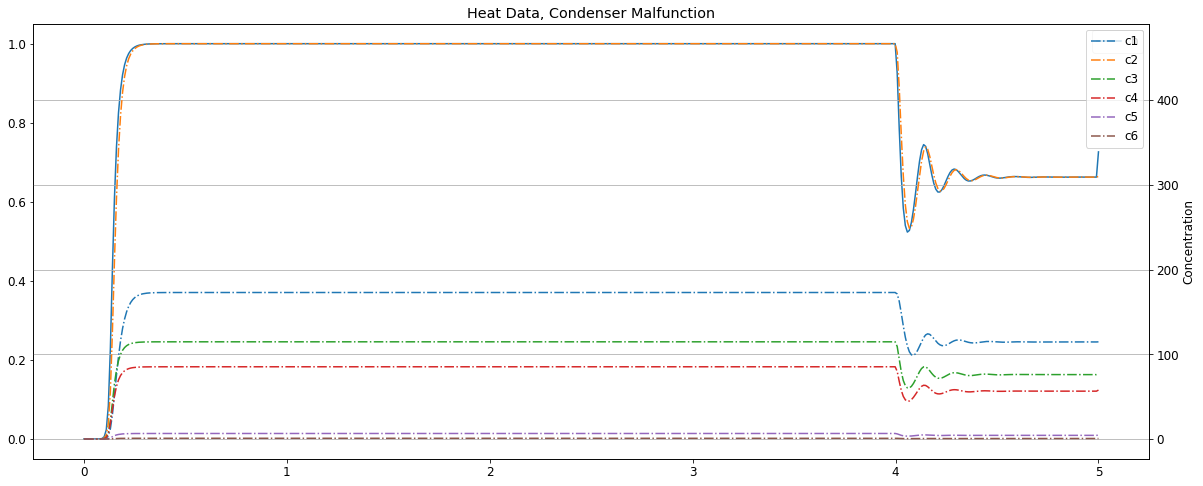

In [49]:
data = plot_results(u_vec_history)
import matplotlib.pyplot as plt
plt.figure(figsize=(22, 8))
fig, ax1 = plt.subplots(1, figsize=(20, 8))
ax1.plot(params['time_stamps']/sc.hour, data['n_dens'])
plt.legend(['n'])
ax2 = ax1.twinx()
ax2.plot(params['time_stamps']/sc.hour, data['c1_dens'], '-.', params['time_stamps']/sc.hour, data['c2_dens'], '-.', params['time_stamps']/sc.hour, data['c3_dens'], '-.', params['time_stamps']/sc.hour, data['c4_dens'], '-.', params['time_stamps']/sc.hour, data['c5_dens'], '-.', params['time_stamps']/sc.hour, data['c6_dens'], '-.',) 
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Concentration')
plt.title('Heat Data, Condenser Malfunction')
plt.legend(['c1', 'c2', 'c3', 'c4', 'c5', 'c6'])

Startup occurs as it should be, but rather interestingly during the condenser malfunction period (4-5 hours), exponentially decreasing sinusoidal oscillation of neutron density and all emitter concentrations can be observed, which settles at new steady state values at around 70% of their normal operating variables. The oscillating behavior of the concentrations mirrors the oscillating temperature reactivity, which is explained in further detail below.

The fact that loss of subcooling in the condenser leads to a decrease in neutron flux is indicitive of a negative moderator temperature reactivity coefficient and therefore a safe reactor.

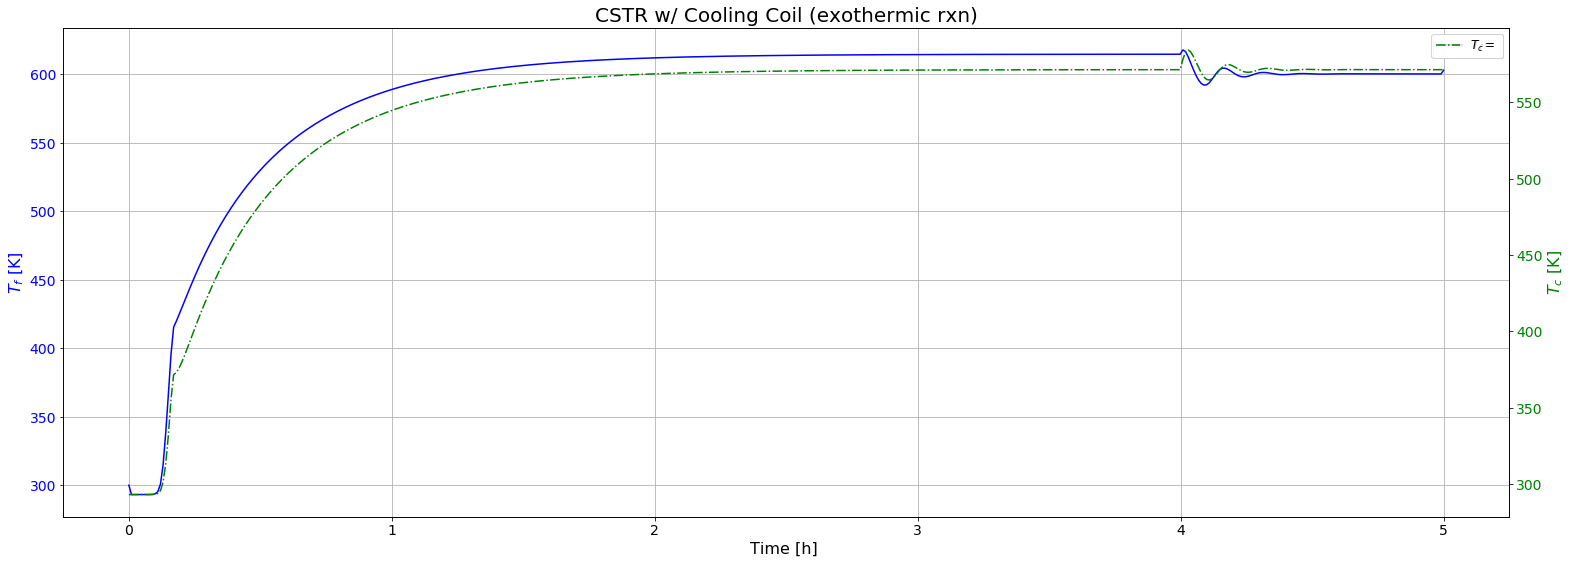

In [50]:
tmp()

During the condenser malfunction, temperature follows the exponentially decreasing sinusoidal waveform found in every other quantity. Initially, the temperature of the coolant and fuel both increase slightly as some subcooling in the inlet coolant is lost, before decreasing and then oscilating until a new steady state temperature is reached. The malfunction steady state value is about 5-10 degrees lower than the normal operating steady state value, which is what the reactor should do if the negative temperature reactivity coefficient is maintained and the reactor is operating safely.

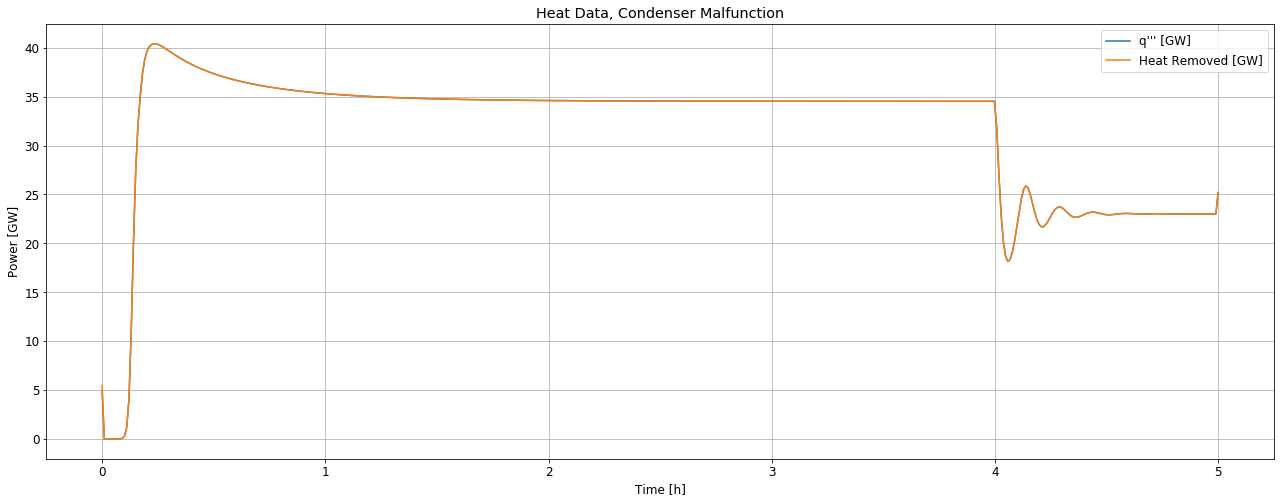

In [51]:
import matplotlib.pyplot as plt
heat_data = reactor.quantities1(u_vec_history, params, params['time_stamps'])
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps']/sc.hour, heat_data["q''' [gW/m3]"], params['time_stamps']/sc.hour, heat_data["heat removed [gW/m3]"])
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Power [GW]')
plt.title('Heat Data, Condenser Malfunction')
plt.legend(["q''' [GW]", 'Heat Removed [GW]'])


Heat removed and q''' mirror the behavior of neutron density during the malfunction, with an exponentially decreasing sinusoidal waveform that reaches a new steady state value of about 65% the magnitude of the old value.

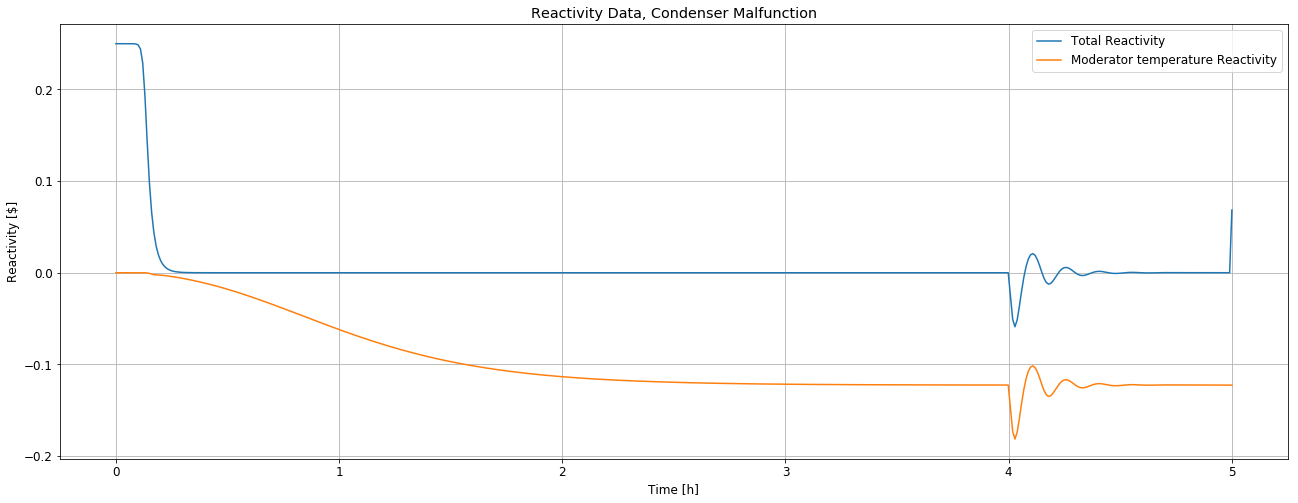

In [52]:
quants = reactor.quantities3(u_vec_history, params, params['time_stamps'])
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps']/sc.hour, quants[0]/params['beta'])
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Reactivity [$]')
plt.title('Reactivity Data, Condenser Malfunction')
plt.legend(['Total Reactivity','Moderator temperature Reactivity'])


During the condenser malfunction, the control blade is kept in the same position. Therefore, any change in moderator temperature will affect the overall reactivity as the control blades will no longer move to compensate for the moderator reactivity coefficient. With reactivity initially being zero, the immediate small increase in moderator temperature due to loss of subcooling leads to a decrease in the moderator temperature reactivity coefficient. This drives reactivity negative, which causes neutron density to initially begin to decrease. This decrease in neutron flux leads to a decrease in the nuclear heat being generated and then a decrease in the temperature of the moderator leaving the reactor due to this. This in turn increases moderator temperature reactivity to above where it was in steady state, leading to a positive reactivity and therefore a smaller increase in neutron density. This pattern of oscillating moderator temperature repeats itself in an exponentially decreasing manner until a new steady state is reached.

This is an important observation, as it clearly demonstrates the inherent safety of a reactor with a negtaive moderator temperature reactivity coefficient and how it helps control the reactor in the event of a condenser or pump malfunction.

Text(0.5, 1.0, 'Regulating Rod Position, Condenser Malfunction')

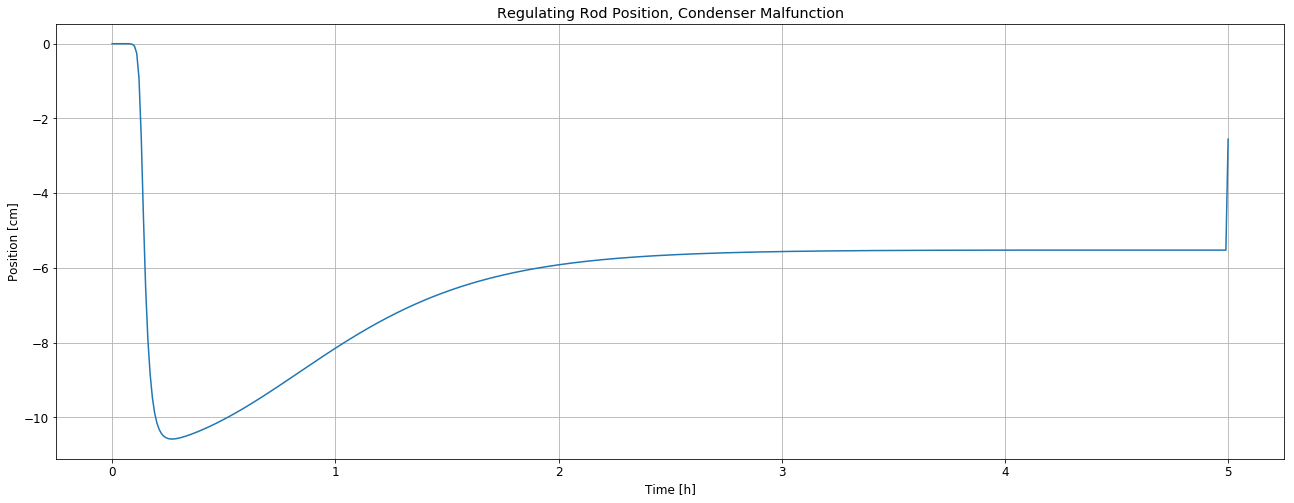

In [53]:
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps']/sc.hour, quants[1])
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Position [cm]')
plt.title('Regulating Rod Position, Condenser Malfunction')

Blade position is fixed during the condenser malfunction and so does not move for the duration of the incident.

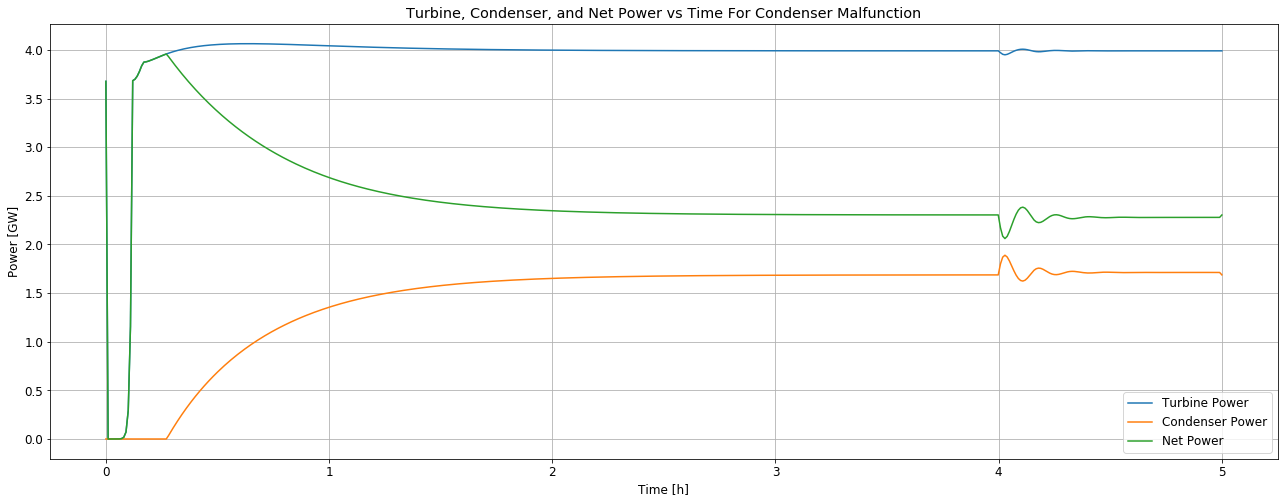

In [54]:
work_data = reactor.quantities2(u_vec_history, params, params['time_stamps'])
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps']/sc.hour, work_data)
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Power [GW]')
plt.title('Turbine, Condenser, and Net Power vs Time For Condenser Malfunction')
plt.legend(['Turbine Power','Condenser Power', 'Net Power'])

Turbine power generated during the malfunction follows an inverse of the oscillations observed in moderator temperature, with decreases in moderator temperature resultiung in decreases in power generated by the turbine and vice versa; The opposite behavior is observed with the condenser, with decreasing moderator temperature leading to an increase in the work required to be done by the condenser. Therefore, a decrease in the temperature of the moderator will lead to a major decrease in the net work produced by the reactor.

<a id="res3"></a>
# Shutdown
The reactor starts up as normal, operates for a certain period of time at steady state, and then shuts down to zero power.

In [13]:
'''Setup up initial conditions'''

import numpy as np
import scipy.constants as sc

params['malfunction start'] = 9999 * sc.hour 
params['malfunction end'] = 9999 * sc.hour + 15 * sc.minute
params['shutdown time'] = 4 * sc.hour

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 0.1

params['n_ss'] = 0 # neutronless steady state before start up

rho_0_over_beta = 0.25 # $
beta = params['beta']

params['alpha_n'] = 0 # control rod reactivity worth; enough to cancel out the negative 

params['reactivity'] = rho_0_over_beta * beta # "rho/beta = 10 cents"

params['temp_0'] = params['temp_o']

params['tau_fake'] = 8 # s
params['malfunction subcooling'] = 0.75
params['alpha_n_malfunction'] = 0

# setup remaining initial conditions
reactor.setup_initial_conditions(params)

In [14]:
'''Evolve the point-reactor'''

time_final    = 12 * sc.hour# 450 # s
n_time_stamps = 1000 # number of solution values in time

params['time_final']    = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = reactor.run_point_reactor( reactor.f_vec, params )
#print(u_vec_history)
print("done")

done


<Figure size 1584x576 with 0 Axes>

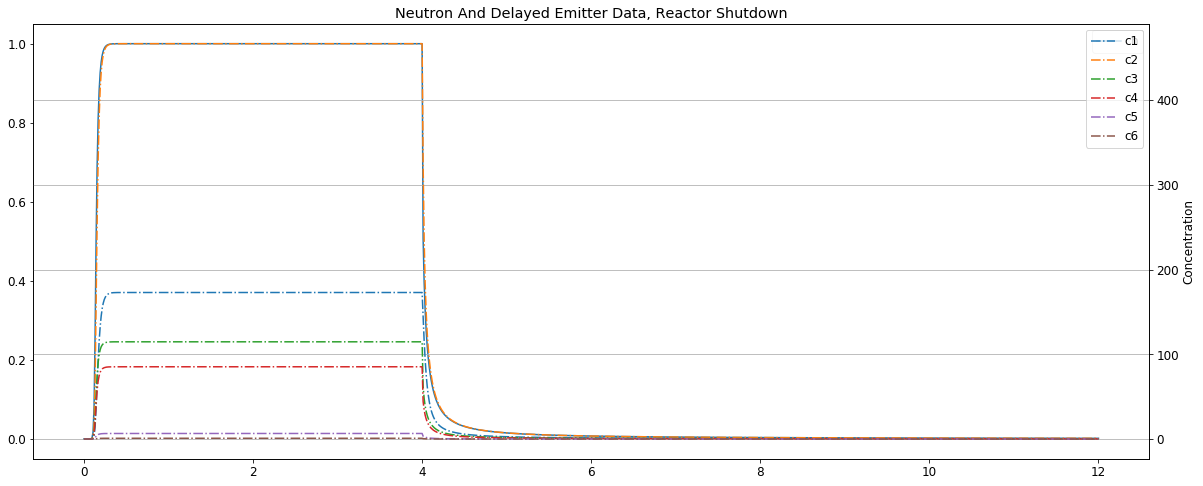

In [15]:
data = plot_results(u_vec_history)
import matplotlib.pyplot as plt
plt.figure(figsize=(22, 8))
fig, ax1 = plt.subplots(1, figsize=(20, 8))
ax1.plot(params['time_stamps']/sc.hour, data['n_dens'])
plt.legend(['n'])
ax2 = ax1.twinx()
ax2.plot(params['time_stamps']/sc.hour, data['c1_dens'], '-.', params['time_stamps']/sc.hour, data['c2_dens'], '-.', params['time_stamps']/sc.hour, data['c3_dens'], '-.', params['time_stamps']/sc.hour, data['c4_dens'], '-.', params['time_stamps']/sc.hour, data['c5_dens'], '-.', params['time_stamps']/sc.hour, data['c6_dens'], '-.',) 
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Concentration')
plt.title('Neutron And Delayed Emitter Data, Reactor Shutdown')
plt.legend(['c1', 'c2', 'c3', 'c4', 'c5', 'c6'])

Neutron density and delayed emitter concentrations behave as expected during shutdown, approaching zero within an hour of shutdown.

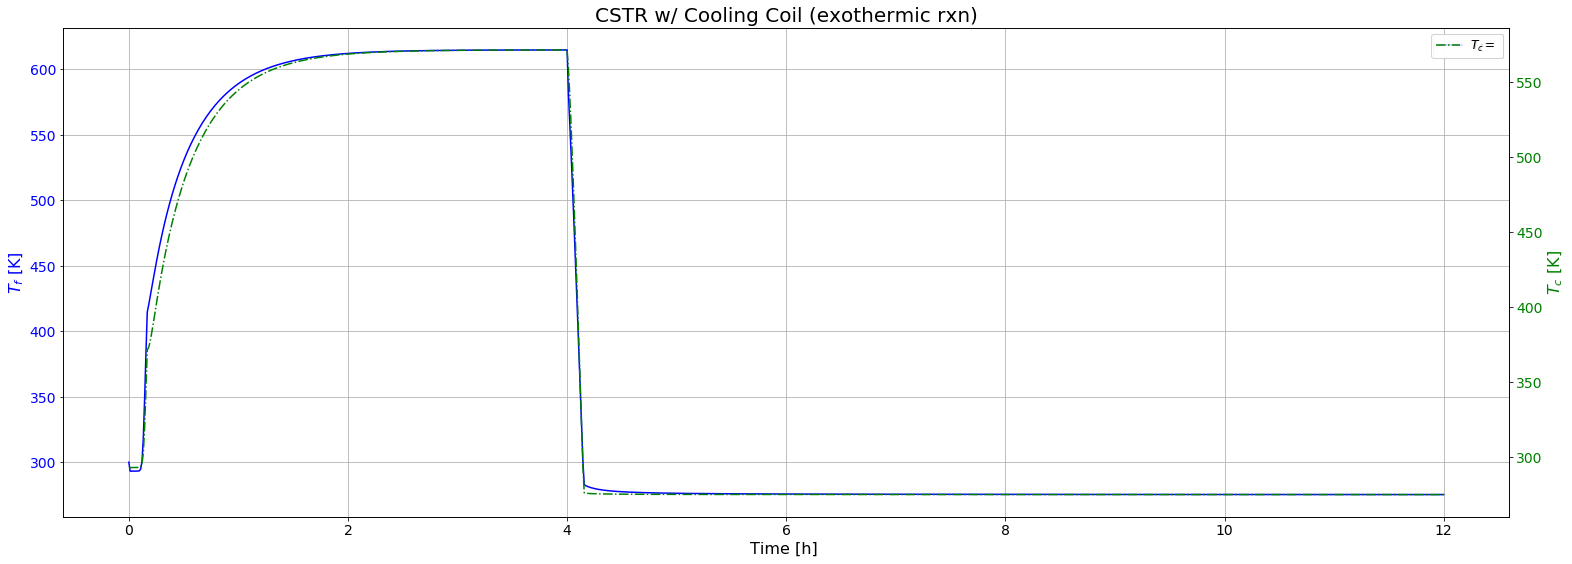

In [16]:
tmp()

Temperature of the moderator and fuel decreases rapidly with time, approaching room temperature for both within 15-20 minutes of shutdown due to the high degree of subcooling present in the condenser.

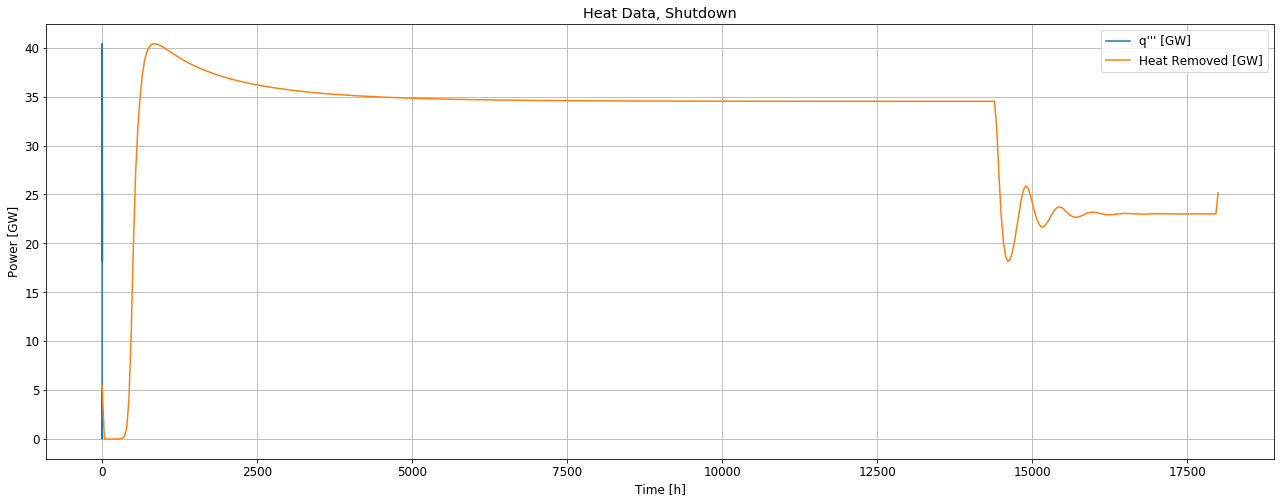

In [55]:
import matplotlib.pyplot as plt
heat_data = reactor.quantities1(u_vec_history, params, params['time_stamps'])
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps']/3600, heat_data["q''' [gW/m3]"], params['time_stamps']/3600, heat_data["heat removed [gW/m3]"])
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Power [GW]')
plt.title('Heat Data, Shutdown')
plt.legend(["q''' [GW]", 'Heat Removed [GW]'])

q''' and heat removed decrease rapidly, never quite reaching zero but approaching it about 12 hours after shutdown in an exponential decrease that is to be expected of the reactor during shutdown.

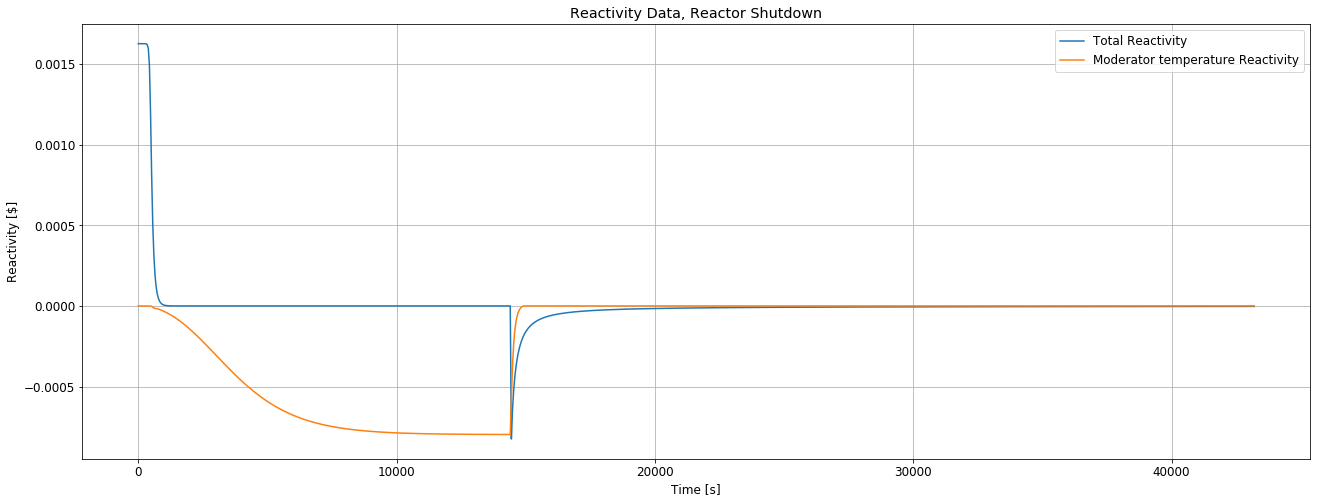

In [18]:
quants = reactor.quantities3(u_vec_history, params, params['time_stamps'])
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps'], quants[0]/params['beta'])
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]/3600')
plt.ylabel('Reactivity [$]')
plt.title('Reactivity Data, Reactor Shutdown')
plt.legend(['Total Reactivity','Moderator temperature Reactivity'])

Total reactivity begins negative and then decreases to zero along with neutron density, as is necessary to shut down the reactor. The moderator temperature reactivity rapidly apporaches zero as the temperature of the reactor returns to that of its surroundings, about 273.15 K.

The initial small decrease in total reactivity can be explained by the fact that neutron density is slightly higher than 1 during steady state due to small roundoff errors introduced by the numerical differential equation solver. Since the total reactivity at any point in time during shutdown is calculated as $-1 * n_\text{dens} * rho_\text{0} $, initial negative reactivity will be slightly lower than $ -1 * rho_\text{0}$

Text(0.5, 1.0, 'Regulating Rod Position, Reactor Shutdown')

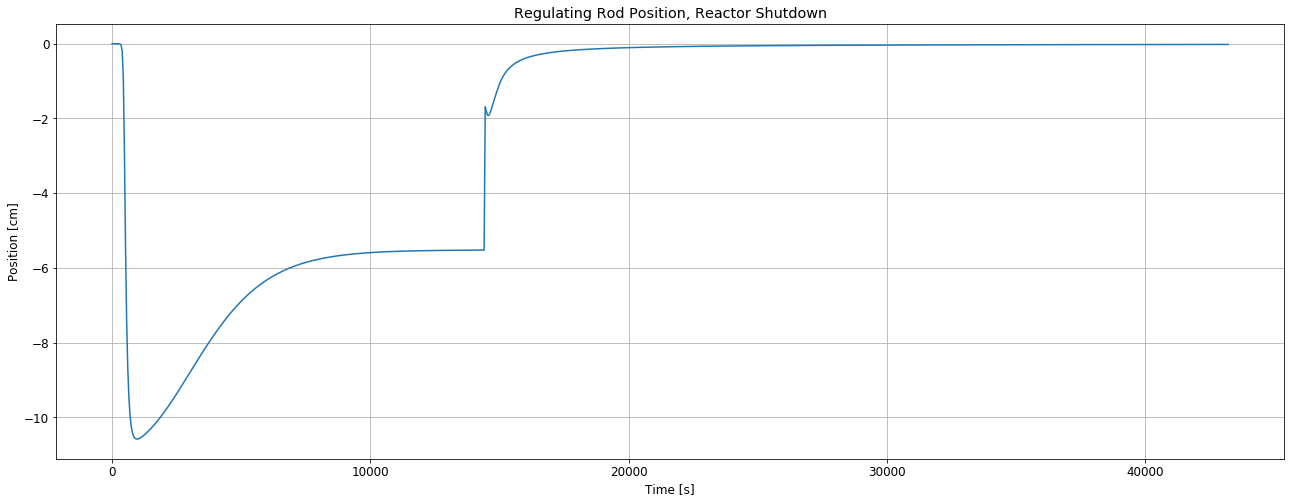

In [19]:
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps']/3600, quants[1])
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Position [cm]')
plt.title('Regulating Rod Position, Reactor Shutdown')

The regulating rod is gradually withdrawn from the reactor as neutron density decreases in order to shut the reactor down and decrease reactivity along with it. The small transient blip that can be observed in the first part of the shutdown is due to the same computational error that leads to the initial blip in total reactivity that is discussed in more detail above.

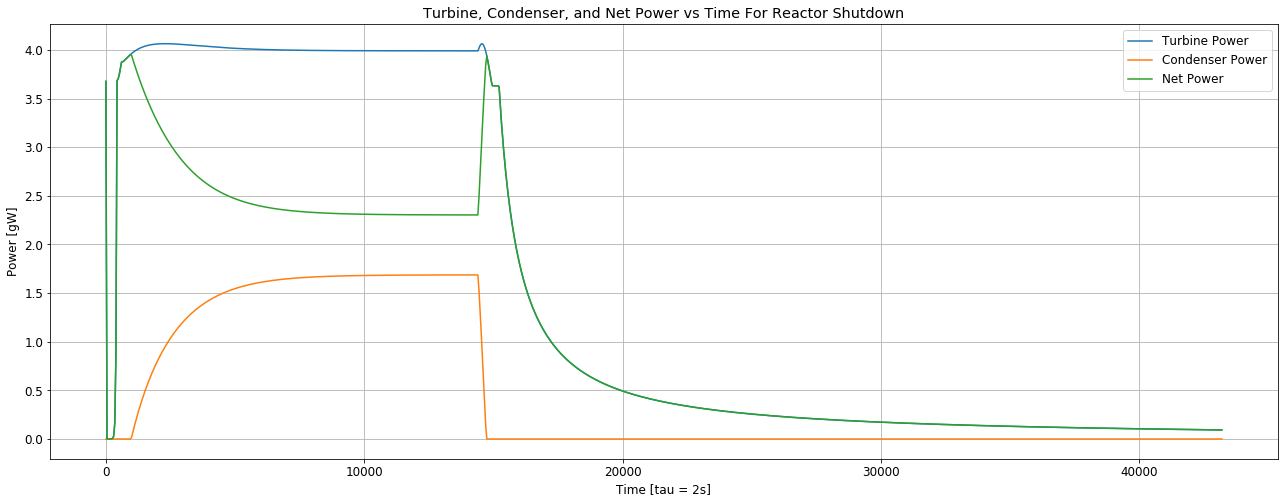

In [20]:
work_data = reactor.quantities2(u_vec_history, params, params['time_stamps'])
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps']/3600, work_data)
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Power [GW]')
plt.title('Turbine, Condenser, and Net Power vs Time For Reactor Shutdown')
plt.legend(['Turbine Power','Condenser Power', 'Net Power'])

Power required by the condenser reaches zero as soon as the desired room temperature steady state coolant temperature is achieved. Initially, power produced by the turbine will exponentially decrease while net power will jump as the power required by the condenser more rapidly approaches zero. Afterwards, both net power and the power produced by the turbine will exponentially decrease to zero, having not quite reached it twelve hours after shutdown.